In [2]:
# Change these file locations as necessary for your metadata and training image file structures

training_metadata = 'metadata_annotations/instances_train_aircraft.json'
training_images = 'PS-RGB_tiled/'

In [ ]:
!pip3 install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
!pip3 install pycocotools

In [6]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from matplotlib import pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import ColorMode
from detectron2.engine import DefaultTrainer
from detectron2.data.datasets import register_coco_instances

from pycocotools.coco import COCO

loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
{'id': 22, 'file_name': '23_104001001E51BE00_tile_1526.png', 'width': 512, 'height': 512}


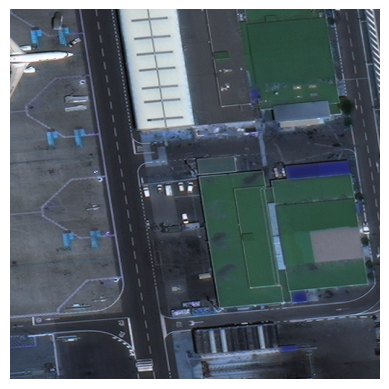

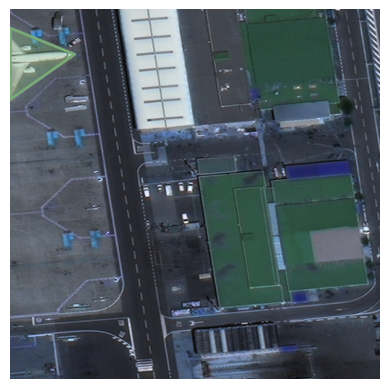

In [21]:
# Let's ensure that our annotation metadata looks correct when displayed on an image
coco=COCO(training_metadata)

# select an image - in this case we're selecting imageID == 22
catIds = coco.getCatIds(catNms=['aircraft']);
imgIds = coco.getImgIds(catIds=catIds);
imgIds = coco.getImgIds(imgIds = [22])
img = coco.loadImgs(imgIds[0])[0]
print(img)

# load and display the image
I = cv2.imread(training_images + img['file_name'])
plt.axis('off')
plt.imshow(I)
plt.show()

# load and display the instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [ ]:
# Register the Rareplanes dataset to detectron2.
register_coco_instances("rareplanes_dataset_train", {}, training_metadata, training_images)

# Configure detectron2 to train using our images and assign values like learning-rate, iterations, etc
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("rareplanes_dataset_train")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # LR => Learning Rate
cfg.SOLVER.MAX_ITER = 300    # 300 iterations is good enough for this example; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (airplane)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [9]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[03/21 20:58:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


loading annotations into memory...
Done (t=0.13s)
creating index...
index created!


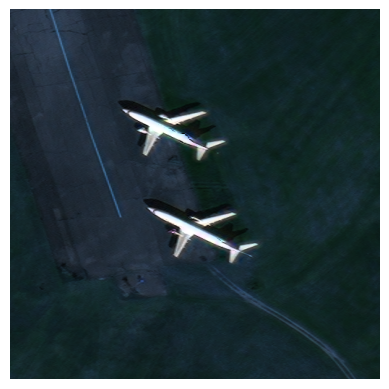

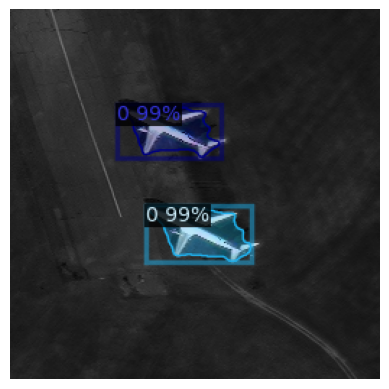

In [28]:
# Let's see if our training worked by outputting an image annotated with predictions
coco_test=COCO(training_metadata)

catIds = coco_test.getCatIds(catNms=['aircraft']);
imgIds = coco_test.getImgIds(catIds=catIds);

# grab a random image to test against
img = coco_test.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

im = cv2.imread(training_images + img['file_name'])
plt.axis('off')
plt.imshow(im)
plt.show()
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1],
               metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), 
               scale=0.5, 
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.axis('off')
plt.imshow(out.get_image()[:, :, ::-1])
plt.show()